In [1]:
import pandas as pd
import geopandas as gpd
from shapely import Point
import requests
from tqdm import tqdm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.family'] = 'DejaVu Sans Mono'
oceans = gpd.read_file('../day3_polygons/ne_10m_ocean.zip')
prj = ccrs.Robinson(central_longitude=0)

In [3]:
def unpack(data):
    _names=[]
    _coords=[]
    _nocoords=[]
    if 'query' in data.keys():
        for k,v in data['query']['pages'].items():
            if 'coordinates' in v.keys():
                _names.append(v['title'])
                _coords.append(Point(v['coordinates'][0]['lon'], v['coordinates'][0]['lat']))
            else:
                _nocoords.append((v['title']))
        return _coords, _names, _nocoords
    else:
        return None, None, None

def get_coords(sub_cat):    
    island_names = []
    island_coords = []
    no_coords = []

    params = {
        "action":"query",
        "generator":"categorymembers",
        "gcmtitle":sub_cat,
        "gcmlimit":'max',
        "prop":"coordinates",
        "coprimary":"all",
        "format":"json"
    }
    url = "https://en.wikipedia.org/w/api.php"
    headers = {'User-Agent': 'island-coordinate-grabber (ej.holt89@gmail.com)'}
    r1 = requests.get(url=url,
                      params=params,
                      headers=headers)
    
    data = r1.json()
    # return data
    coords, names, nocoords = unpack(data)
    if coords == None:
        return None, None, None
    else:
        island_coords += coords
        island_names += names
        no_coords += nocoords
        
        i = 1
        while True:
            if 'continue' in data.keys():
                # print(f'must continue: #{i}')
                pcopy = params.copy()
                pcopy.update(data['continue'])
                nextbatch = requests.get(url=url,params=pcopy,headers=headers)
                data = nextbatch.json()
                coords, names, nocoords = unpack(data)
                island_coords += coords
                island_names += names
                no_coords += nocoords
                i += 1
            else:
                break
        
        return island_names, island_coords, list(set(no_coords))

def automate(cats):
    island_dict = {}
    no_coords = {}
    for cat in tqdm(cats):
        island_names, island_coords, missing = get_coords(cat)
        if island_names==None:
            continue
        else:
            island_dict[cat] = dict(zip(island_names,island_coords))
            no_coords[cat] = missing
        
    gdf = gpd.GeoDataFrame.from_dict({(i,j): island_dict[i][j] 
                            for i in island_dict.keys() 
                            for j in island_dict[i].keys()},
                            orient='index',
                            columns=['geometry'],
                            crs=4326)

    gdf.index = pd.MultiIndex.from_tuples(gdf.index,
                                        names=['country','island'])
    gdf=gdf.reset_index()    
            
    return gdf, no_coords #coord_less, new_cats, still_missing

In [4]:
S = requests.Session()
url = "https://en.wikipedia.org/w/api.php"
headers = {'User-Agent': 'island-coordinate-grabber (ej.holt89@gmail.com)'}
params = {
    "action": "query",
    "list":"categorymembers",
    "cmtitle":'Category:Uninhabited_islands_by_country',
    "cmtype":'subcat',
    "cmlimit":"max",
    "format":"json",
}
R = requests.get(url=url, params=params, headers=headers)
uninhab_by_country = [m['title'] for m in R.json()['query']['categorymembers']]

In [5]:
gdfs = []

cats = uninhab_by_country
for rep in range(4):
    gdf, missing = automate(cats)
    flattened = [val for sublist in list(missing.values()) for val in sublist]
    cats = [i for i in flattened if i not in gdf['island'].tolist()]
    gdfs.append(gdf)
    
cats = [c for c in cats if 'Category:Uninhabited islands' in c]
gdf, missing = automate(cats)
gdfs.append(gdf)

all = pd.concat(gdfs).reset_index(drop=True)
all = all.loc[all['geometry'].drop_duplicates().index].reset_index()

100%|██████████| 13/13 [00:43<00:00,  3.34s/it]


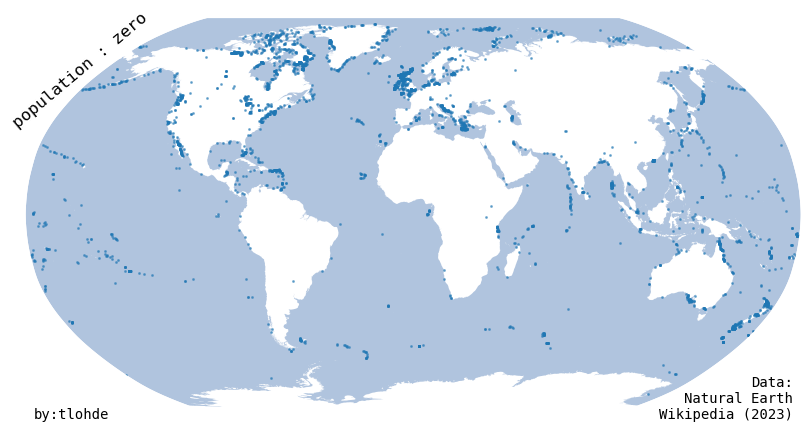

In [7]:
fig, ax = plt.subplots(figsize=[10,10],
                       subplot_kw={'projection':prj})

oceans.to_crs(prj).plot(color='lightsteelblue',
                        ax=ax)

all.to_crs(prj).plot(marker='.',
                     markersize=5,
                    #  fc='none',
                    #  ec='k',
                     alpha=0.5,
                     ax=ax)

ax.set_axis_off()

ax.set_title('population : zero', x=0.07, y=0.7, rotation=40, ha='center')

ax.annotate(text='Data:\nNatural Earth\nWikipedia (2023)',
            xy=(0.99,-0.02), 
            xycoords='axes fraction', 
            ha='right',
            c='k', 
            fontsize=10)

ax.annotate(text='by:tlohde',
            xy=(0.01,-0.02), 
            xycoords='axes fraction',
            ha='left',
            fontsize=10)

fig.savefig('day29.png', dpi=300, bbox_inches='tight')